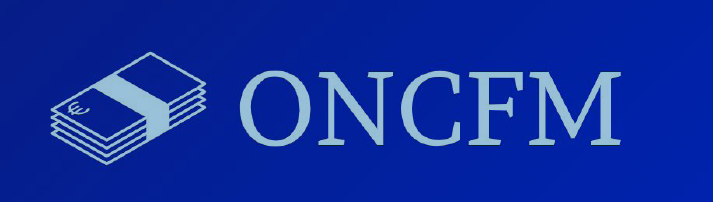

In [1]:
# import librairies & utils

# utilities
import os
os.environ["OMP_NUM_THREADS"] = '1'  # needed to avoid memory leak warning with K-Means in Windows environment
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)  # ignore all future warnings

# data
import numpy as np
import pandas as pd

# modelisation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# custom user-defined functions
from functions import *

# 1 - Import et verification des donnees

In [2]:
# Import data
data_prod = pd.read_csv('billets_final.csv', encoding='latin_1')
data_test = pd.read_csv('BILLETS_TEST.csv', encoding='latin_1')  # check file name

# split file - include all variables for K-means
x_train_kmeans = data_prod[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].values
x_test_kmeans = data_test[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].values

# split file - include only variables that are statistically significant for Logistic Regession (p-value < 5%)
x_train_logreg = data_prod[['height_right', 'margin_low', 'margin_up', 'length']].values
y_train = data_prod['is_genuine']
x_prod_logreg = data_prod[['height_right', 'margin_low', 'margin_up', 'length']].values
x_test_logreg = data_test[['height_right', 'margin_low', 'margin_up', 'length']].values

# banknotes = data.index
dimensions = data_prod.columns.drop('is_genuine')
# dimensions = data_prod.columns.drop(['is_genuine', 'diagonal', 'height_left'])

print("Table test: \n")
# check for missing values in test dataframe
if (data_test.loc[data_test.isna().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes.")
# check for missing data in test dataframe
if (data_test.loc[data_test.isnull().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles.")
# check for duplicates in test dataframe
if (data_test.loc[data_test.duplicated() == True].shape[0]) != 0:
    print("!!! Doublons dans la table !!!")
else:
    print ("Pas de doublons.")
    
# check for data input size
if (data_test.shape != (5,7)):
    print("Mauvais format de donnees.")
else:
     print("Format de donnees ok. \n")

print(f"Nous avons x_train_kmeans de forme {x_train_kmeans.shape}.")
print(f"Nous avons x_test_kmeans de forme {x_test_kmeans.shape}. \n")

print(f"Nous avons x_train_logreg de forme {x_train_logreg.shape} et y_train de forme {y_train.shape}")
unique_yt, counts_yt = np.unique(y_train, return_counts=True)
print("True/False mix dans le training set pour la regression logistique:\n", np.asarray((unique_yt, counts_yt)).T)
print(f"Nous avons x_test_logreg de forme {x_test_logreg.shape}.")

# center & reduce data
std_scaler_kmeans = StandardScaler()
std_scaler_logreg = StandardScaler()

# fit StandardScaler on training set only to prevent data leakage
x_train_kmeans_scaled = std_scaler_kmeans.fit_transform(x_train_kmeans)
x_train_logreg_scaled = std_scaler_logreg.fit_transform(x_train_logreg)

# transform test set with Standard Scaler
x_test_kmeans_scaled = std_scaler_kmeans.transform(x_test_kmeans)
x_test_logreg_scaled = std_scaler_logreg.transform(x_test_logreg)

Table test: 

Pas de valeurs manquantes.
Pas de valeurs nulles.
Pas de doublons.
Format de donnees ok. 

Nous avons x_train_kmeans de forme (1500, 6).
Nous avons x_test_kmeans de forme (5, 6). 

Nous avons x_train_logreg de forme (1500, 4) et y_train de forme (1500,)
True/False mix dans le training set pour la regression logistique:
 [[   0  500]
 [   1 1000]]
Nous avons x_test_logreg de forme (5, 4).


# 2 - Detecteur par K-Means

## 2.1 - Entrainement du modele

In [3]:
# run K-means with optimised parameters
kmeans_3 = KMeans(n_clusters=3, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300, verbose=0,
                  random_state=42, tol=0.00001)
kmeans_3.fit(x_train_kmeans_scaled)
labels_3 = kmeans_3.labels_

# create dataframe to store results
clusters = data_prod.copy()
clusters.loc[(clusters['is_genuine'] == True), 'labels_true'] = 1
clusters.loc[(clusters['is_genuine'] == False), 'labels_true'] = 0

# add cluster number to each banknote in clusters dataframe
clusters['cluster_km_3'] = (kmeans_3.labels_ + 1)

# build confusion matrix
conf_km3 = confusion(clusters['labels_true'], clusters['cluster_km_3'])
conf_km3 = pd.DataFrame(conf_km3)

# assign labels to clusters based on max values in confusion matrix
val_km3_1 = conf_km3['pred_1'].idxmax()
clust_km3_1 = bool(int(val_km3_1[-1]))
val_km3_2 = conf_km3['pred_2'].idxmax()
clust_km3_2 = bool(int(val_km3_2[-1]))
val_km3_3 = conf_km3['pred_3'].idxmax()
clust_km3_3 = bool(int(val_km3_3[-1]))

## 2.2 - Application du modele aux donnees de production

In [4]:
# run optimised K-means on test data
kmeans_3.fit_predict(x_test_kmeans_scaled)
labels_final_test = kmeans_3.labels_

# add cluster number to each country in clusters dataframe
clusters_test = data_test.copy()
clusters_test['cluster_pred_test'] = (labels_final_test + 1)

# automatically reassign cluster numbers to True/False banknotes labels
clusters_test.loc[clusters_test['cluster_pred_test'] == 1, 'labels_pred_test'] = clust_km3_1
clusters_test.loc[clusters_test['cluster_pred_test'] == 2, 'labels_pred_test'] = clust_km3_2
clusters_test.loc[clusters_test['cluster_pred_test'] == 3, 'labels_pred_test'] = clust_km3_3

# print results
print("Resultats:\n")
for k, l in zip(clusters_test["labels_pred_test"], clusters_test["id"]):
    if k == 1:
        print(f"Le billet ref. {l} est un vrai billet.")
    else:
        print(f"Le billet ref. {l} est un faux billet.")

Resultats:

Le billet ref. B_1 est un faux billet.
Le billet ref. B_2 est un vrai billet.
Le billet ref. B_3 est un faux billet.
Le billet ref. B_4 est un vrai billet.
Le billet ref. B_5 est un vrai billet.


# 3 - Detecteur par Regression Logistique

## 3.1 - Entrainement du modele

In [5]:
# fit model to train data using optimised hyper-parameters
best_params_saga = {'C': 0.001, 'class_weight': None, 'max_iter': 500, 'penalty': 'none', 'random_state': 42,
                    'solver': 'saga'}
estimator_final = LogisticRegression(**best_params_saga)
estimator_final.fit(x_train_logreg_scaled, y_train.values.ravel())
y_pred_final = estimator_final.predict(x_train_logreg_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


## 3.2 - Application du modele aux donnees de production

In [6]:
# predict banknote type on test data
results = data_test.copy()
results['proba'] = estimator_final.predict_proba(x_test_logreg_scaled)[:, 1].ravel()
results.loc[results['proba'] > 0.5, 'labels_pred_reglog'] = True
results.loc[results['proba'] <= 0.5, 'labels_pred_reglog'] = False
results

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba,labels_pred_reglog
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,9.991207e-01,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,3.361738e-04,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,9.999603e-01,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,2.003279e-07,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,2.231481e-03,False


In [7]:
# print results
print("Resultats:\n")
for i, j in zip(results["labels_pred_reglog"], results["id"]):
    if i == 1:
        print(f"Le billet ref. {j} est un vrai billet.")
    else:
        print(f"Le billet ref. {j} est un faux billet.")

Resultats:

Le billet ref. B_1 est un vrai billet.
Le billet ref. B_2 est un faux billet.
Le billet ref. B_3 est un vrai billet.
Le billet ref. B_4 est un faux billet.
Le billet ref. B_5 est un faux billet.
